## Описание проекта
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.


Информация о договорах актуальна на 1 февраля 2020.

# Предобработка данных

In [1]:
import pandas as pd
import numpy as np
import math

from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from functools import reduce
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import datetime
from sklearn.model_selection import GridSearchCV, cross_val_score
from catboost import CatBoostClassifier, Pool, cv
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
try:
    contract = pd.read_csv('final_provider/contract.csv')
    personal = pd.read_csv('final_provider/personal.csv')
    internet = pd.read_csv('final_provider/internet.csv')
    phone = pd.read_csv('final_provider/phone.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
def describe_df(df):
    print(df.info())
    print('-------------')
    print(df.describe())
    print('-------------')
    print(df.isna().sum())
    print('-------------')
    print(df.duplicated().sum())

In [4]:
contract.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3860,9862-KJTYK,2018-07-01,No,Month-to-month,Yes,Credit card (automatic),25.35,566.1
946,6231-WFGFH,2019-10-01,No,Month-to-month,Yes,Mailed check,20.50,77.6
6736,7558-IMLMT,2014-07-01,No,Two year,Yes,Mailed check,20.80,1411.9
6474,7196-LIWRH,2019-08-01,No,Two year,No,Mailed check,19.55,124.45
6487,5998-DZLYR,2015-01-01,No,Two year,Yes,Bank transfer (automatic),94.35,5703


In [5]:
describe_df(contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
-------------
       MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000
-------------
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64
-------------
0


`TotalCharges` не float. В то же время пропусков там нет. Переведём во float

In [6]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'],errors='coerce')

Создадим столбец с целевым признаком `Is_gone` – остался клиент или ушел. 

Если `EndDate` = No, то `Is_gone` = 0, клиент ещё не ушёл. Иначе `Is_gone` = 1.

In [7]:
contract['Is_gone'] = (contract['EndDate'] != 'No').astype(int)

In [8]:
def bar_plot(df, feature, b):
    data = df[feature]
    bins = np.arange(b) - 0.5
    plt.hist(data, bins, color='#607c8e', alpha=0.7)
    plt.xticks(range(b-1))
    plt.xlabel('Counts')
    plt.grid(axis='y', alpha=0.75)
    plt.title(feature +' distribution')

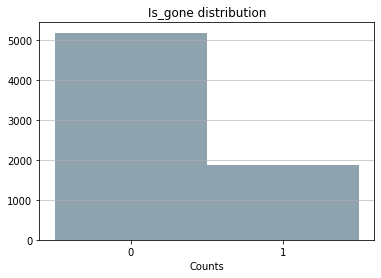

In [9]:
bar_plot(contract,'Is_gone', 3)

Заметен дисбаланс классов целевого признака. Модель может обучиться неправильно.

Что можно попробовать:
- upsampling
- балансировка классов
- downsampling, хотя это не кажется хорошим вариантом
___

In [10]:
contract.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Is_gone
4164,7030-FZTFM,2014-02-01,No,Two year,No,Credit card (automatic),110.90,7922.75,0
4805,2207-RYYRL,2015-10-01,No,Two year,No,Mailed check,24.55,1331.05,0
6563,6906-ANDWJ,2018-10-01,2020-01-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),74.90,1107.25,1
3129,7080-TNUWP,2014-04-01,No,One year,Yes,Bank transfer (automatic),95.00,6602.90,0
5897,0562-HKHML,2014-03-01,No,Two year,No,Credit card (automatic),23.90,1626.40,0


Сравним распределения величин ежемесячных платежей (MonthlyCharges) всех клиентов

In [11]:
def plt_compare(df, f1, b, s1, s2):
    plt.figure(figsize=(s1,s2))
    df[f1][df['Is_gone']==1].hist(bins=b, alpha=0.5, label='Is_gone = 0', color='red')
    df[f1][df['Is_gone']==0].hist(bins=b, alpha=0.4, label='Is_gone = 1')
    plt.xticks(rotation='vertical')
    plt.ylabel('Count')
    plt.xlabel(f1)
    plt.legend()
    plt.title(f1 + ' distribution')
    plt.show()

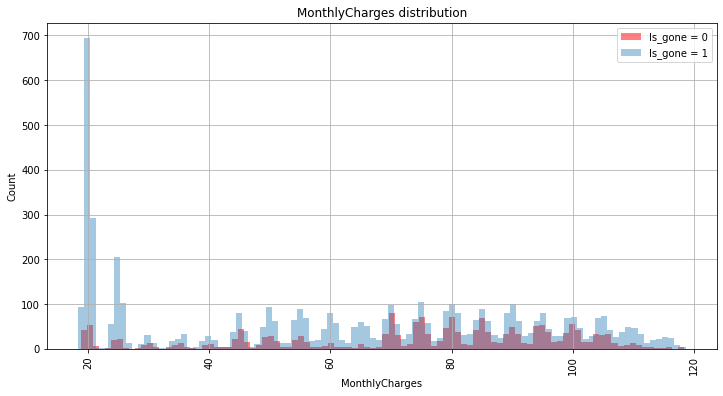

In [12]:
plt_compare(contract, 'MonthlyCharges', 100, 12, 6)

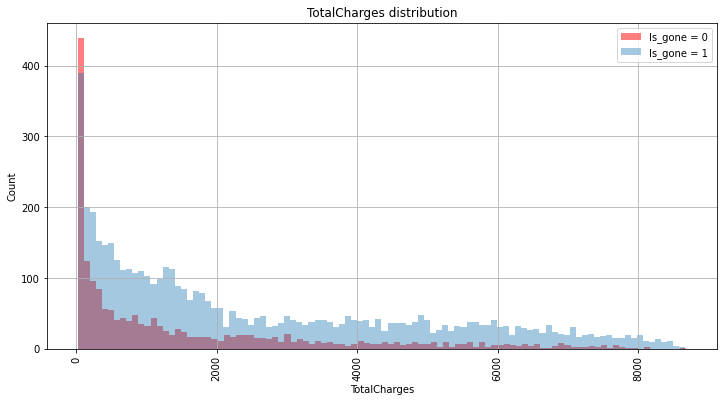

In [13]:
plt_compare(contract, 'TotalCharges', 100, 12, 6)

Стоит оставить оба признака, т.к. картина в целом отличается и 'TotalCharges' очевидно не складываются только из 'MonthlyCharges', к ним добавляются доп. услуги

_______

Когда чаще всего уходили клиенты:

In [14]:
contract.query('Is_gone == 1')[['EndDate']].describe()

,EndDate
count,1869
unique,4
top,2019-11-01 00:00:00
freq,485


<mark> здесь и в следующей ячейке не прогружались графики. очень странно, потому что в локальной тетрадке всё работало.
    
<mark>В принципе, эта табличка тоже неплохо репрезентует ответ "Когда чаще всего уходили клиенты?". Ссылка на график прикреплена

<mark>График здесь: https://pasteboard.co/K3QXa0w.png

Когда чаще всего приходили клиенты: ушедшие и оставшиеся:

In [15]:
contract.sort_values(by="BeginDate")[contract['Is_gone']==1][['BeginDate']].describe()

,BeginDate
count,1869
unique,75
top,2019-09-01
freq,168


In [16]:
contract.sort_values(by="BeginDate")[contract['Is_gone']==0][['BeginDate']].describe()

,BeginDate
count,5174
unique,73
top,2014-02-01
freq,356


Очень много из ушедших присоединились феврале-марте 2014-го. Можно предположить, что была какая-то большая скидка. Так же можно сказать и про начало 2020-го. Видимо, надо будет предотвратить отток пришедших в октябре-декабре 2019

<mark> График здесь https://pasteboard.co/K3QY4k8.png
    
<mark> Таблички дают схожее представление с визуальным анализом графика. На крайний случай этого будет достаточно

In [17]:
personal.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
877,7876-AEHIG,Female,0,No,Yes
6477,3518-FSTWG,Male,1,Yes,No
6479,4351-QLCSU,Female,0,No,No
5988,6828-HMKWP,Male,0,Yes,Yes
6709,7103-IPXPJ,Male,0,Yes,No


In [18]:
describe_df(personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
-------------
       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
-------------
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
-------------
0


In [19]:
personal.pivot_table(index=('gender'), values='customerID', aggfunc=('count'))

,customerID
gender,
Female,3488
Male,3555


Практически равные значения для гендеров
_________
Узнаем количество пользователей пенсионного возраста

In [20]:
personal.pivot_table(index=('SeniorCitizen'), values='customerID', aggfunc=('count'))

,customerID
SeniorCitizen,
0,5901
1,1142


Таким образом, в `personal` представлены данные о 7043 клиентах из них 3555 мужчин и 3488 женщин. 1142 пенсионного возраста

In [21]:
internet.sample(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
2972,7868-BGSZA,DSL,Yes,No,Yes,No,Yes,Yes
1848,1552-AAGRX,Fiber optic,Yes,No,No,Yes,Yes,Yes
4584,4550-EVXNY,Fiber optic,No,No,No,No,No,No
3002,3932-CMDTD,Fiber optic,No,Yes,Yes,Yes,Yes,Yes
2843,2722-JMONI,DSL,Yes,No,No,No,No,No


In [22]:
describe_df(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB
None
-------------
        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     4282-YMKNA     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV StreamingMovies  
count              5517        5517        5517            5517  
unique                2           2       

Сколько пользователей не пользовались интернетом в через эту компанию.

Т.е. в таблице договоров `contract` они есть, а в `internet` - нет

In [23]:
len(contract)-len(internet)

1526

Для всех, кто есть в таблице создадим признак `Internet` со значением 1

In [24]:
internet['Internet'] = 'Yes'

___

In [25]:
phone.sample(5)

,customerID,MultipleLines
1842,7694-VLBWQ,Yes
1455,7552-KEYGT,No
2947,7779-LGOVN,Yes
5567,3982-XWFZQ,Yes
5343,0269-XFESX,Yes


In [26]:
describe_df(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB
None
-------------
        customerID MultipleLines
count         6361          6361
unique        6361             2
top     4282-YMKNA            No
freq             1          3390
-------------
customerID       0
MultipleLines    0
dtype: int64
-------------
0


Сколько пользователей не пользовались телефонной связью.

Т.е. в таблице договоров `contract` они есть, а в `phone` - нет

In [27]:
len(contract) - len(phone)

682

Соответственно, можно создать признак `phone`, который равен 1, если пользователь есть в таблице `phone` и 0 если отсутствует (682)

In [28]:
phone['Phone'] = 'Yes'

Соберём всё в одну таблицу

In [29]:
df = contract.merge(personal, how='left', on='customerID').merge(internet, how='left', on='customerID').merge(phone, how='left', on='customerID')
df = df.set_index('customerID')
df.sample(5)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Is_gone,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Internet,MultipleLines,Phone
customerID,,,,,,,,,,,,,,,,,,,,,
0536-BGFMZ,2017-10-01,No,Month-to-month,No,Mailed check,20.50,563.05,0,Female,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes
8066-POXGX,2018-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,35.10,446.10,1,Female,0,...,DSL,No,No,No,No,No,Yes,Yes,NaN,NaN
9648-BCHKM,2018-08-01,No,Two year,Yes,Credit card (automatic),24.65,471.35,0,Female,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes
5329-KRDTM,2014-02-01,No,Two year,No,Credit card (automatic),77.35,5396.25,0,Male,1,...,DSL,No,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes
3729-OWRVL,2014-09-01,No,Two year,Yes,Electronic check,110.35,7246.15,0,Male,1,...,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes


In [30]:
describe_df(df)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 22 columns):
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
Is_gone             7043 non-null int64
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
Internet            5517 non-null object
MultipleLines       6361 non-null object
Phone               63

Пропуски скорее всего означают отсутствие услуг

Однако в `InternetService` тип подключения не может быть задан, посмотрим какие значения существуют

In [31]:
df['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

Не будем заполнять ни модой, ни медианным значением. Добавим ещё одно значение Undefined


In [32]:
df['InternetService'] = df['InternetService'].fillna('Undefined')
df['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Undefined      1526
Name: InternetService, dtype: int64

Посмотрим записи c пропусками в `TotalCharges`, т.к. это наверняка клиенты, которые лишь 1-й месяц поользуются услугами компании, о них пока ничего не понятно

In [33]:
df[df['TotalCharges'].isnull()]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Is_gone,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Internet,MultipleLines,Phone
customerID,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,Female,0,...,DSL,Yes,No,Yes,Yes,Yes,No,Yes,NaN,NaN
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,0,Male,0,...,Undefined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,0,Female,0,...,DSL,Yes,Yes,Yes,No,Yes,Yes,Yes,No,Yes
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,0,Male,0,...,Undefined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,0,Female,0,...,DSL,Yes,Yes,Yes,Yes,Yes,No,Yes,NaN,NaN
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,0,Male,0,...,Undefined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,0,Male,0,...,Undefined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,0,Female,0,...,Undefined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,0,Male,0,...,Undefined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes


Присвоим этим записям нулевую общую оплату

In [34]:
df['TotalCharges'] = df['TotalCharges'].fillna(0)

Оставшиеся пропуски заполним как 'No'

In [35]:
null_cols = []
for col in df.columns:
    if df[col].isnull().sum() > 0:
        null_cols.append(col)
print(null_cols)
df[null_cols] = df[null_cols].fillna('No')

['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Internet', 'MultipleLines', 'Phone']


Преобразуем типы дат и создадим признак `Duration`, который будет описывать длительность договора. 

Дату начала и дату конца договора удалим, т.к. это может привести к утечке данных

In [36]:
df.loc[(df['EndDate'] == 'No'), 'EndDate'] = '2020-02-01'
df['EndDate'] = pd.to_datetime(df['EndDate'])
df['BeginDate'] = pd.to_datetime(df['BeginDate'])

df['Duration'] = (pd.to_datetime(df['EndDate']) -
                  pd.to_datetime(df['BeginDate'])).dt.days
df['Duration'] = df['Duration'].astype('int')

del df['BeginDate'], df['EndDate']

Все столбцы с Yes и No переведём в формат 1 и 0

In [37]:
for column in df:
    tmp = df[column].unique()
    if list(tmp) == ['No', 'Yes'] or list(tmp) == ['Yes', 'No']:
        df[column] = (df[column] == 'Yes').astype('int')
        df[column] = df[column].astype('int')

Посмотрим на значения в категориальных переменных

In [38]:
df['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [39]:
df['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Undefined      1526
Name: InternetService, dtype: int64

In [40]:
df['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

Заготовим признаки для ohe кодирования в случае, если они категориальные. Численные признаки потом отмасштабируем. Гендер сразу включать не будем, т.к. этот признак ни на что не влияет.

In [41]:
ohe_names = ['PaymentMethod', 'InternetService', 'Type']
numeric_names = ["TotalCharges", "MonthlyCharges", "Duration"]
target_name = 'Is_gone'

features_names = list(df.columns)
features_names.remove(target_name)
features_names.remove('gender')

categories = [x for x in features_names if x not in numeric_names]

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
Type                7043 non-null object
PaperlessBilling    7043 non-null int64
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
Is_gone             7043 non-null int64
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null int64
Dependents          7043 non-null int64
InternetService     7043 non-null object
OnlineSecurity      7043 non-null int64
OnlineBackup        7043 non-null int64
DeviceProtection    7043 non-null int64
TechSupport         7043 non-null int64
StreamingTV         7043 non-null int64
StreamingMovies     7043 non-null int64
Internet            7043 non-null int64
MultipleLines       7043 non-null int64
Phone               7043 non-null int64
Duration            7043 non-null int64
dtypes: float64(2), int64(15), obje

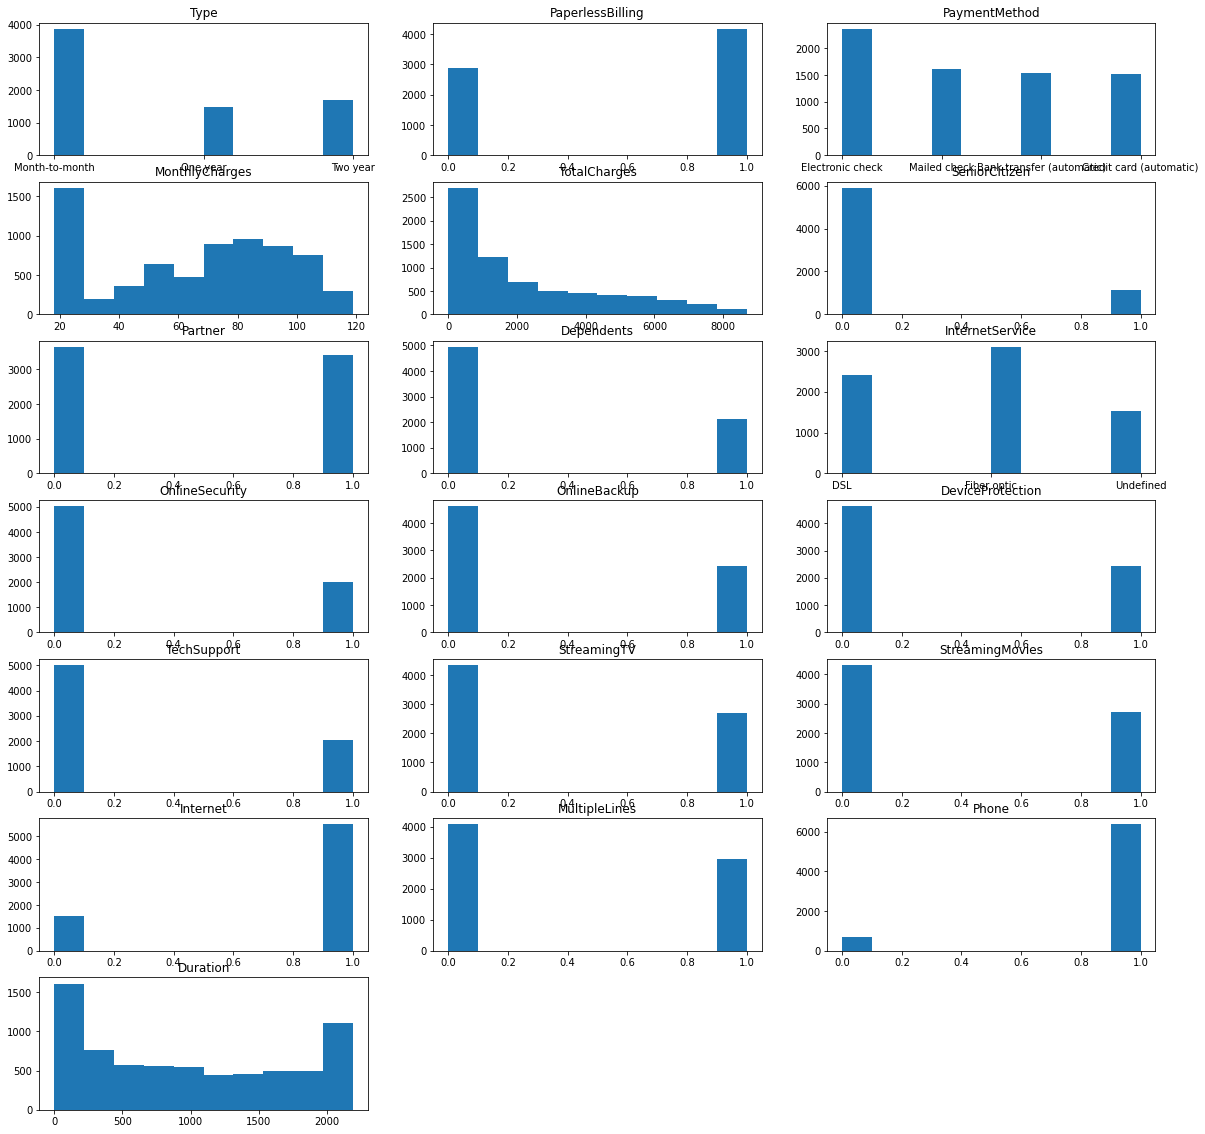

In [43]:
ncols = 3
nrows = math.ceil(len(features_names) / ncols)

plt.figure(figsize=(20, 20))

counter = 0
for feature in features_names:
    counter += 1
    plt.subplot(nrows, ncols, counter)
    plt.hist(df[feature])
    plt.title(feature)

Посмотрим на аналогичное распределение, но уже с учётом, ушли клиенты или нет

Судя по графикам, дополнительные услуги не популярны. Похожие графики говорят о том, что, если этими услугами пользуются, то, скорее всего, одни и те же люди. 

Учитывая дисбаланс в целевом признаке, стоит обратить внимание на значимость признаков.

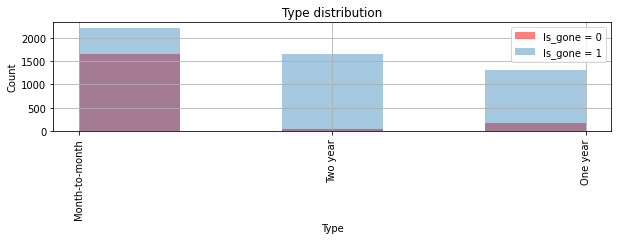

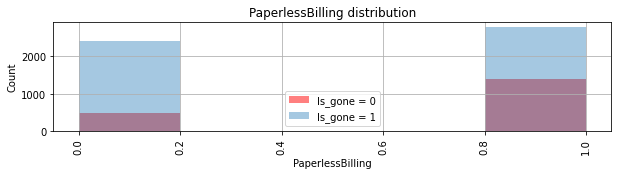

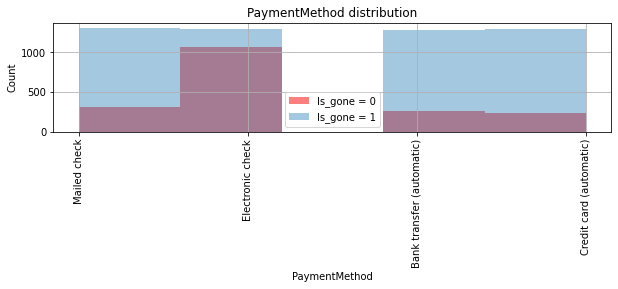

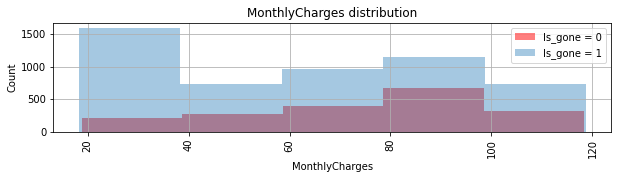

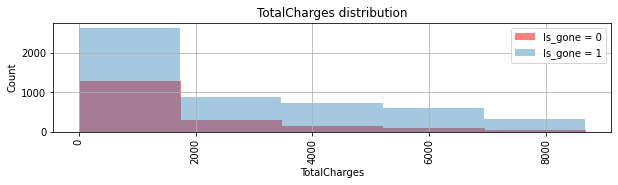

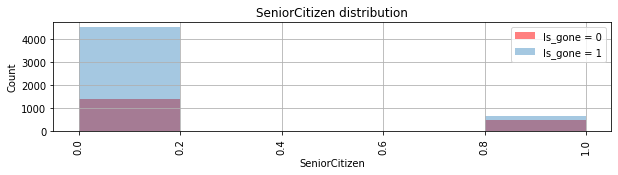

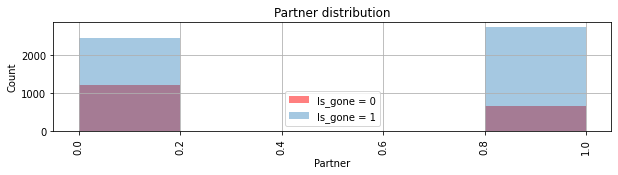

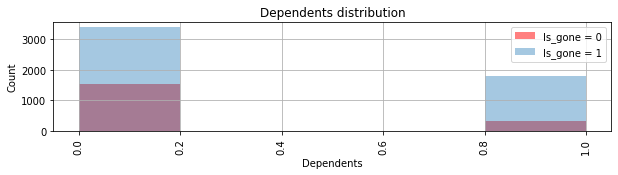

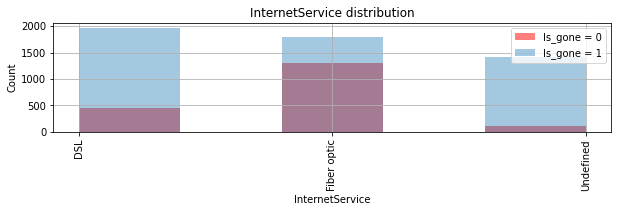

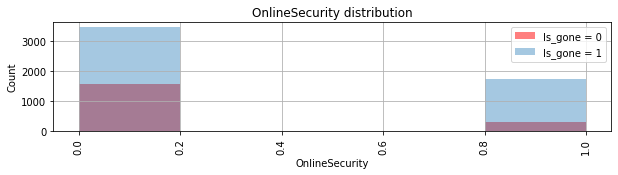

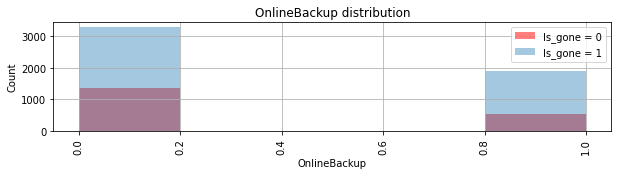

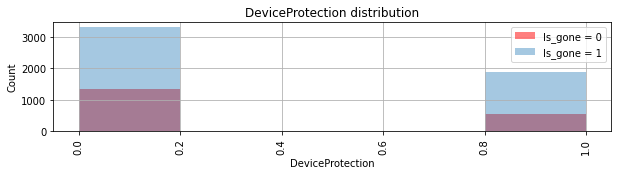

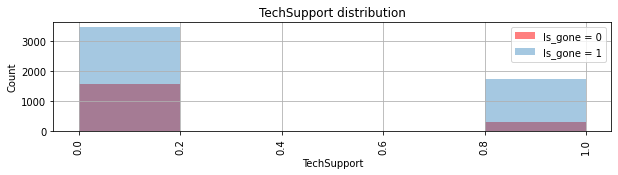

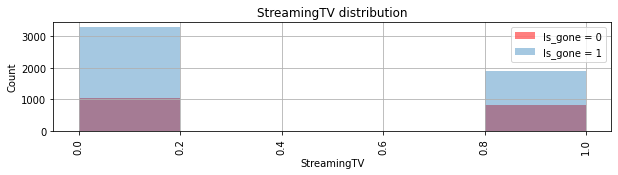

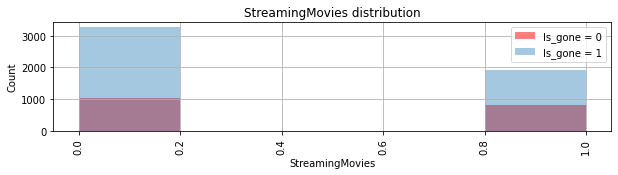

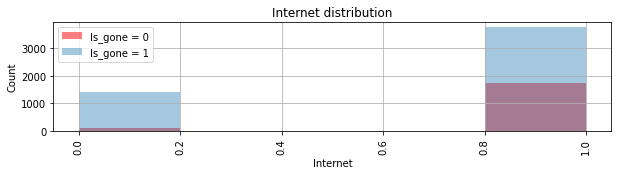

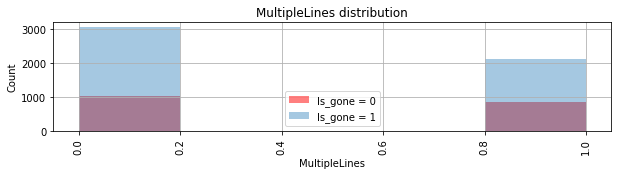

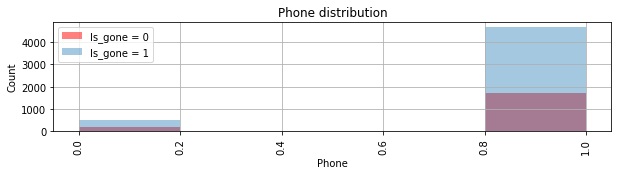

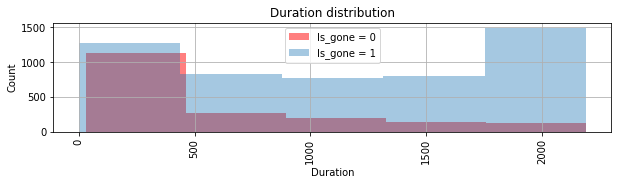

In [44]:
for feature in features_names:
    plt_compare(df, feature , 5, 10, 2)

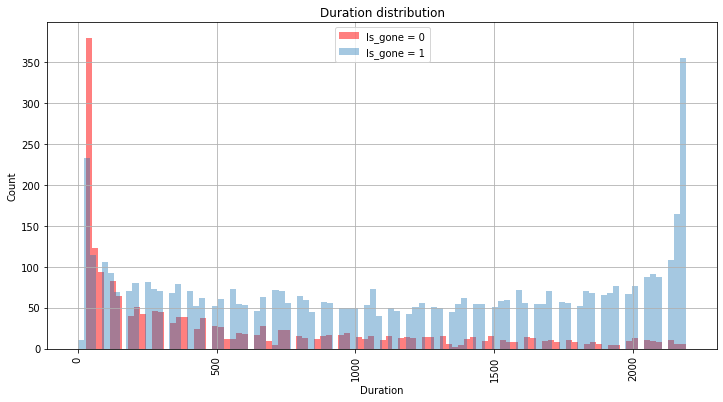

In [45]:
plt_compare(df, 'Duration' , 100, 12, 6)

Удалим из датасета признак `gender`, он очевидно не влияет на целевой признак

In [46]:
df = df.drop('gender', axis=1)

Среди абонентов с оплатой сразу за год или за два - минимальный отток. 
Но это может быть связано с нехваткой данных, для адекватного оценивания хотелось бы иметь примерно столько же записей как и для оплаты по месяцам (или лет на 10 вперёд). Или потому что численно их меньше. В процентном соотношении отток относительно оставшихся пользователей ощутим;

По графику количества дней использования (`Duration`) видно, что много отказов связано с использованием до двух месяцев (не отказавшиеся – это те, кто присоединились за 2 месяца до выгрузки данных?), при этом, не считая порога в 2 месяца, чем больше время пользования, тем отказов больше;

Дополнительные услуги оказывают малое влияние на то, ушёл клиент или нет (пропорционально отказы почти везде одинаковы, как у тех, кто ими пользуется, так и у тех, кто нет)
Среди тех, кто не пользуется интернетом и телефоном отказов меньше всего. Это касается признаков `Internet` и `Phone` и значения Undefined в `InternetService`

По отказам много клиентов с DSL (потом переходят на оптику?). От оптики тоже часто отказывааются. Похоже, компании надо подтянуть работу с "интернетными" клиентами.

# Обучение моделей

Корреляция данных

In [48]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,PaperlessBilling,MonthlyCharges,TotalCharges,Is_gone,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Internet,MultipleLines,Phone,Duration
PaperlessBilling,1,0.35215,0.158574,0.191825,0.15653,-0.0148766,-0.111377,-0.0036359,0.126735,0.103797,0.0378799,0.223841,0.211716,0.321013,0.16353,0.0165048,0.00605925
MonthlyCharges,0.35215,1,0.651174,0.193356,0.220173,0.0968479,-0.11389,0.296594,0.44178,0.482692,0.338304,0.629603,0.627429,0.763557,0.490434,0.247398,0.247754
TotalCharges,0.158574,0.651174,1,-0.198324,0.103006,0.317504,0.0620782,0.411651,0.509226,0.521983,0.431883,0.514973,0.520122,0.375223,0.468504,0.113214,0.826109
Is_gone,0.191825,0.193356,-0.198324,1,0.150889,-0.150448,-0.164221,-0.171226,-0.0822549,-0.0661598,-0.164674,0.0632277,0.0613815,0.22789,0.0401021,0.011942,-0.352673
SeniorCitizen,0.15653,0.220173,0.103006,0.150889,1,0.0164787,-0.211185,-0.0386527,0.0665721,0.0594285,-0.0606246,0.105378,0.120176,0.182742,0.142948,0.0085764,0.016514
Partner,-0.0148766,0.0968479,0.317504,-0.150448,0.0164787,1,0.452676,0.143106,0.141498,0.153786,0.119999,0.124666,0.117412,-0.000615165,0.142057,0.0177057,0.379709
Dependents,-0.111377,-0.11389,0.0620782,-0.164221,-0.211185,0.452676,1,0.0809717,0.023671,0.0139625,0.0632681,-0.0165577,-0.039741,-0.139812,-0.0245258,-0.00176168,0.159766
OnlineSecurity,-0.0036359,0.296594,0.411651,-0.171226,-0.0386527,0.143106,0.0809717,1,0.283832,0.275438,0.354931,0.176207,0.187398,0.333403,0.0981081,-0.0928927,0.327203
OnlineBackup,0.126735,0.44178,0.509226,-0.0822549,0.0665721,0.141498,0.023671,0.283832,1,0.303546,0.294233,0.282106,0.274501,0.381593,0.202237,-0.0523122,0.360238
DeviceProtection,0.103797,0.482692,0.521983,-0.0661598,0.0594285,0.153786,0.0139625,0.275438,0.303546,1,0.333313,0.390874,0.402111,0.380754,0.201137,-0.0712269,0.360602


<mark> Посмотрим на корреляцию всех признаков: корреляция `Duration` и `TotalCharges` > 0.8. Значит, дольше остаются те, кто больше платит 
    
<mark> Попробуем удалить `TotalCharges`. Потому что пользование доп услугами уже отмечено в признаках, а общая стоимость складывается из месячной платы + поользование доп услугами.
    
<mark> Есть идея, что `Phone` и `Internet` тоже излишни, но видимо корреляция Спирмена/Пирсона не дает полного представления. Посмотрим позже на коэффициенты Variance Inflation Factor (VIF)

In [49]:
del df['TotalCharges']

In [50]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [51]:
RANDOM_STATE=42

Разделим выборку на train и test в соотношении 4 : 1

Используем get_feature_importance у CatBoost, чтобы оценить значение признаков

In [52]:
features_names = list(df.columns)
features_names.remove(target_name)

In [53]:
df_features = df[features_names]
df_target = df[target_name]

features_train, features_test, target_train, target_test = train_test_split(df_features, df_target, test_size=0.2, random_state=RANDOM_STATE)

train_pool = Pool(data=features_train, label=target_train, cat_features=categories, feature_names=features_names)
v_counts = target_train.value_counts()
scale_pos_weight = v_counts[0] / v_counts[1]

scale_pos_weight

2.766042780748663

In [54]:
catboost = CatBoostClassifier(verbose=0, scale_pos_weight=scale_pos_weight, task_type="CPU", random_seed=RANDOM_STATE)
catboost.fit(train_pool)

In [55]:
features_and_score = list(zip(catboost.feature_names_, catboost.get_feature_importance()))
df_score = pd.DataFrame(features_and_score)
df_score = df_score.sort_values(by=1, ascending=False)
df_score

,0,1
17,Duration,50.460320
0,Type,12.537741
3,MonthlyCharges,8.802538
7,InternetService,7.062469
2,PaymentMethod,4.872238
1,PaperlessBilling,2.023906
13,StreamingMovies,1.919892
11,TechSupport,1.711138
15,MultipleLines,1.671224
8,OnlineSecurity,1.605108


График feature importance

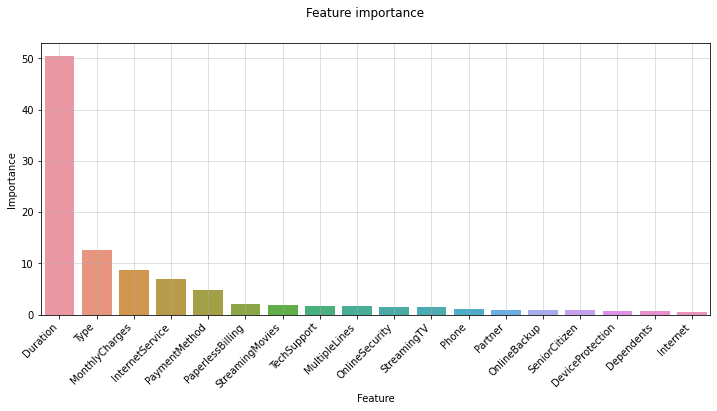

In [56]:
fig, ax = plt.subplots(figsize=(12,5))
fig.suptitle('Feature importance')
sns.barplot(y=df_score[1], x=df_score[0], ax=ax, data=df_score)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.grid(True, alpha=0.5)
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

Оставим признаки со `score` > 1

In [57]:
del df['OnlineBackup'], df['Internet'], df['SeniorCitizen'], df['Partner'], df['DeviceProtection']

Категориальные признаки закодируем с помощью OHE (для строковых данных это делается с помощью `get_dummies`

In [58]:
df.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,Is_gone,Dependents,InternetService,OnlineSecurity,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Phone,Duration
customerID,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,1,Electronic check,29.85,0,0,DSL,0,0,0,0,0,0,31
5575-GNVDE,One year,0,Mailed check,56.95,0,0,DSL,1,0,0,0,0,1,1036
3668-QPYBK,Month-to-month,1,Mailed check,53.85,1,0,DSL,1,0,0,0,0,1,61
7795-CFOCW,One year,0,Bank transfer (automatic),42.30,0,0,DSL,1,1,0,0,0,0,1371
9237-HQITU,Month-to-month,1,Electronic check,70.70,1,0,Fiber optic,0,0,0,0,0,1,61


In [59]:
df = pd.get_dummies(df, drop_first=True)

features_names = list(df.columns)
features_names.remove(target_name)

df_features = df[features_names]
df_target = df[target_name]

features_train, features_test, target_train, target_test = train_test_split(df_features, df_target, test_size=0.2, random_state=RANDOM_STATE)

In [60]:
df.head()

,PaperlessBilling,MonthlyCharges,Is_gone,Dependents,OnlineSecurity,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Phone,Duration,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_Undefined
customerID,,,,,,,,,,,,,,,,,,
7590-VHVEG,1,29.85,0,0,0,0,0,0,0,0,31,0,0,0,1,0,0,0
5575-GNVDE,0,56.95,0,0,1,0,0,0,0,1,1036,1,0,0,0,1,0,0
3668-QPYBK,1,53.85,1,0,1,0,0,0,0,1,61,0,0,0,0,1,0,0
7795-CFOCW,0,42.30,0,0,1,1,0,0,0,0,1371,1,0,0,0,0,0,0
9237-HQITU,1,70.70,1,0,0,0,0,0,0,1,61,0,0,0,1,0,1,0


In [61]:
X = df.iloc[:,:-1]
calc_vif(X)

,variables,VIF
0,PaperlessBilling,2.882057
1,MonthlyCharges,60.555950
2,Is_gone,1.813960
3,Dependents,1.528734
4,OnlineSecurity,2.334400
5,TechSupport,2.430472
6,StreamingTV,3.407876
7,StreamingMovies,3.461241
8,MultipleLines,2.517122
9,Phone,12.345588


<mark> про VIF говорится, что значения больше 5 означают мультиколлинеарность. Т.е. признак с VIF > 5 можно выразить через другие. 

<mark>Судя по всему, таковым является `MonthlyCharges`. Оплата формируется из услуг и тарифа, это логично, но напрямую выразить её невозможно, и так `TotalCharges` уже удалено..</mark>
    
    
<mark> **Можно попробовать удалить `Phone`**

In [62]:
del df['Phone']

Проведём масштабирование числовых признаков

In [63]:
numeric_names = ['MonthlyCharges', 'Duration']

In [64]:
scaler = StandardScaler()
scaler.fit(features_train[numeric_names])

features_train[numeric_names] = scaler.transform(features_train[numeric_names])
features_test[numeric_names] = scaler.transform(features_test[numeric_names])

features_train[numeric_names].sample(5, random_state=RANDOM_STATE)

,MonthlyCharges,Duration
customerID,,
9501-UKKNL,-0.437545,1.092194
0060-FUALY,0.993322,1.092194
2951-QOQTK,0.529662,-1.162285
0337-CNPZE,1.377214,0.352359
5862-BRIXZ,-0.136747,0.558168


Для апсемплинга надо узнать соотношение классов. идеальное – 1:1. 

In [65]:
coef = target_train[target_train == 1].count() / target_train[target_train == 0].count()
coef

0.36152730787820203

Проведём апсемплинг, а затем посмотрим на получившееся распределение

In [66]:
def upsample(features, target, coef):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    repeat = round(1 / coef)
    features_upsampled = pd.concat([features_zeros] + [features_ones] * int(repeat))
    target_upsampled = pd.concat([target_zeros] + [target_ones] * int(repeat))
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=RANDOM_STATE)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, coef)
target_upsampled.value_counts()

1    4488
0    4138
Name: Is_gone, dtype: int64



### Логистическая регрессия

In [67]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
model = LogisticRegression(solver='lbfgs', penalty='l2')
grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid.fit(features_upsampled, target_upsampled)
grid.best_params_

{'C': 1}

In [68]:
model = LogisticRegression(solver='lbfgs', penalty='l2', C=10)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
predicted_proba = model.predict_proba(features_test)[:, 1]
print('accuracy:', accuracy_score(target_test, predicted_test))
print('ROC AUC:', roc_auc_score(target_test, predicted_proba))

accuracy: 0.7452093683463449
ROC AUC: 0.8601007173393233


In [69]:
def make_roc_curve(target_test, predicted_test):
    fpr, tpr, thresholds = roc_curve(target_test, predicted_test)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.show()

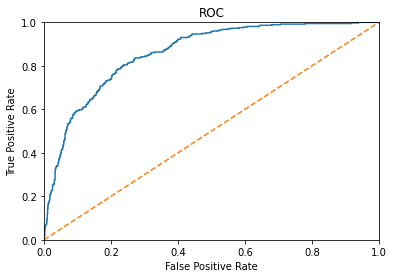

In [70]:
make_roc_curve(target_test, predicted_proba)

### Random Forest

Коммент в подборе параметров, чтобы не пересчитывать каждый раз

In [71]:
%%time

param_grid = {
    'max_depth': [2, 10, 20, 30, 40],
    'min_samples_split': range(2, 11, 2),
    'min_samples_leaf': range(2, 11, 2),
    'n_estimators': range(50, 101, 10)
}

model = RandomForestClassifier(random_state=RANDOM_STATE)

'''grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid.fit(features_upsampled, target_upsampled)
grid.best_params_'''

CPU times: user 92 µs, sys: 29 µs, total: 121 µs
Wall time: 128 µs


"grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')\ngrid.fit(features_upsampled, target_upsampled)\ngrid.best_params_"

Лучшие параметры:

{'max_depth': 30,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 90}

In [72]:
model = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=30, min_samples_leaf=2, n_estimators=90, min_samples_split=2)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
predicted_proba = model.predict_proba(features_test)[:, 1]
print('accuracy:', accuracy_score(target_test, predicted_test))
print('ROC AUC:', roc_auc_score(target_test, predicted_proba))

accuracy: 0.7849538679914834
ROC AUC: 0.8540931298974195


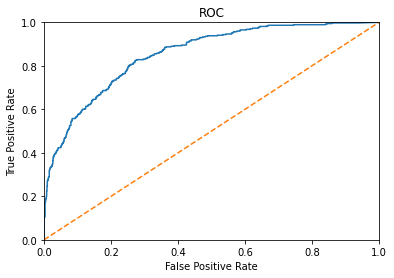

In [73]:
make_roc_curve(target_test, predicted_proba)

### Catboost

Catboost с параметрами по умолчанию:

In [74]:
%%time

feature_names = list(features_upsampled.columns)
cat_features = list(set(feature_names) - set(numeric_names))

train_pool = Pool(data=features_upsampled, label=target_upsampled, 
                  cat_features=cat_features, feature_names=feature_names)
test_pool = Pool(data=features_test, label=target_test, 
                 cat_features=cat_features, feature_names=feature_names)

catboost = CatBoostClassifier(verbose=0, task_type="CPU", devices='0:1', random_seed=RANDOM_STATE)
catboost.fit(train_pool)

predicted_test = catboost.predict(test_pool)
predicted_proba = model.predict_proba(features_test)[:, 1]

print('accuracy:', accuracy_score(target_test, predicted_test))
print('ROC AUC:', roc_auc_score(target_test, predicted_proba))

accuracy: 0.8665720369056068
ROC AUC: 0.8540931298974195
CPU times: user 29.3 s, sys: 3.73 s, total: 33 s
Wall time: 34.8 s


In [75]:
%%time

param_grid = {
    'iterations':[100, 1000],
    'learning_rate': [0.01, 0.1, 0.3],
    'depth': range(6, 11, 2), 
    'l2_leaf_reg': range(3, 10, 2),
    'border_count':[128], 
}

'''model = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', task_type="GPU", devices='0:1', random_seed=RANDOM_STATE, thread_count=-1)
gs_result = model.grid_search(param_grid, train_pool, verbose=0, train_size=0.8, plot=False, partition_random_seed=RANDOM_STATE)
gs_result['params']'''

CPU times: user 24 µs, sys: 0 ns, total: 24 µs
Wall time: 28.6 µs


'model = CatBoostClassifier(loss_function=\'Logloss\', eval_metric=\'AUC\', task_type="GPU", devices=\'0:1\', random_seed=RANDOM_STATE, thread_count=-1)\ngs_result = model.grid_search(param_grid, train_pool, verbose=0, train_size=0.8, plot=False, partition_random_seed=RANDOM_STATE)\ngs_result[\'params\']'

Лучшие параметры:

{'border_count': 128,
 'depth': 10,
 'l2_leaf_reg': 9,
 'iterations': 1000,
 'learning_rate': 0.3}
 
 Сначала попробуем меньше итераций

In [76]:
model = CatBoostClassifier(loss_function='Logloss', depth=10, 
                           l2_leaf_reg=5, eval_metric='AUC', iterations=100, 
                           learning_rate=0.5, task_type="CPU", devices='0:1', 
                           random_seed=RANDOM_STATE, thread_count=-1, border_count=128, verbose=0)
model.fit(train_pool, eval_set = [(features_test, target_test)], use_best_model=True)
predicted_test = model.predict(test_pool)
predicted_proba = model.predict_proba(test_pool)[:, 1]
print('accuracy:', accuracy_score(target_test, predicted_test))
print('ROC AUC:', roc_auc_score(target_test, predicted_proba))

accuracy: 0.8388928317955997
ROC AUC: 0.9094475555601561


In [ ]:
model = CatBoostClassifier(loss_function='Logloss', depth=10, 
                           l2_leaf_reg=9, eval_metric='AUC', iterations=1000, 
                           learning_rate=0.3, task_type="CPU", devices='0:1', 
                           random_seed=RANDOM_STATE, thread_count=-1, border_count=128, verbose=0)
model.fit(train_pool, eval_set = [(features_test, target_test)], use_best_model=True)
predicted_test = model.predict(test_pool)
predicted_proba = model.predict_proba(test_pool)[:, 1]
print('accuracy:', accuracy_score(target_test, predicted_test))
print('ROC AUC:', roc_auc_score(target_test, predicted_proba))

In [ ]:
make_roc_curve(target_test, predicted_proba)

# Вывод

В первой части работы были исследованы данные, был выделен целевой признак `Is_gone`. Данные были объединены в одну таблицу, обработаны пропуски и ошибки. Построены распределения признаков в зависимости от целевого. А так же выделены новые признаки – пользуется ли клиент услугами телефона/интернета и длительность контракта.

В ходе исследования данных было выяснено:
- Среди тех, кто платит помесячно доля отказов примерно равная, а среди оплат сразу за год или за два - минимальная, хотя неизвестно, может они не будут продлевать контракт по истечении текущего. Хотелось бы больше данных по этим оплатам.

- По графику количества дней использования видно, что наибольшие отказы связаны с использованием до двух месяцев. Далее, чем больше время пользования, тем меньше отказов. На рубеже 2-х месяцев компании стоит сделать какое-то выгодное предложение, чтобы клиент остался дальше.

- Общее количество потраченных денег влияет на отток, что подтверждает необходимость в том, чтобы сохранить клиента в самом начале

- Среди тех, кто не пользуется интернет услугами компании, отказов меньше всего. Вероятно, интернет-услуги стоит улучшить для уменьшения оттока.

- Дополнительные услуги оказывают наименьшее влияние на отток клиентов, несмотря на то, что они иногда определяют суммарные затраты пользователя, которые влияют на отток.


Для моделей были оставлены только наиболее значимые признаки. Значения ROC AUC после удаления `TotalCharges` и `Phone` для Catboost улучшились

К числовым данным применено масштабирование, к категориальным OHE. Так же был проведён апсемплинг.

Мы попробовали и обучили разные модели. В качестве метрики была посчитана как ROC-AUC, так и accuracy. 

Полученные результаты (ROC-AUC; accuracy):

- Логистическая регрессия: 86,01; 0,75%  
- Случайный лес: 85,42; 0,79% 
- CatBoost:	91,68%; 0,84

Наилучшая модель – CatBoost. Благодаря ей был преодолен  порог ROC-AUC в 88%. Любопытно, что логистическая регрессия оказалась на втором месте.



# Отчёт
Наибольшая часть выводов по работе есть в предыдущей ячейке "Вывод". Что стоит добавить:

Ключевые пункты плана были выполнены, шаги в решении задачи полностью соответствуют ему. Такие шаги как стекинг/блендинг не использовались, т.к. необходимого значения ROC-AUC удалось добиться с помощью CatBoost.

Трудностей при выполнении проекта не возникало.

Ключевым моментом оказалась генерация новых признаков (целевой `Is_gone` и длительность контракта `Duration`).

Так же оказался важным отбор наиболее значимых признаков. Были удалены `TotalCharges` и `Phone`, т.к. имели высокий коэффициент корреляции с другими признаками.
Признаки со значением feature importance < 1 так же были удалены. График feature importance можно показывать коллегам 🙂

В итоге с помощью **CatBoost**  удалось достичь показателя **ROC-AUC = 91,68%** и **accuracy = 0.84**